## Objective

The purpose is to train a baseline model on the X-ray dataset to predict whether the images are 'NORMAL' or 'PNEUMONIA'. This will be one of the models used for analysis via the innvestigate module.

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Basic imports

In [3]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import sys

# Run this if you are using google colab
sys.path.append('/content/drive/My Drive/')

from src.utils import *

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


In [0]:
!unzip -q 'drive/My Drive/Chest_X_rays/chest-xray-pneumonia.zip'

The data is now stored in the chest_xray folder.

In [0]:
path = 'chest_xray/chest_xray/'
train_path = path + 'train/'
test_path = path + 'test/'
val_path = path + 'val/'

In [6]:
# Get the first 50 samples in training path : 'NORMAL' & 'PNEUMONIA'
samples_normal, samples_pneumonia, _, _ = get_data(train_path,50)

Files in first 50 images of chest_xray/chest_xray/train/NORMAL appended!
Files in first 50 images of chest_xray/chest_xray/train/PNEUMONIA appended!


## Visualise a few samples

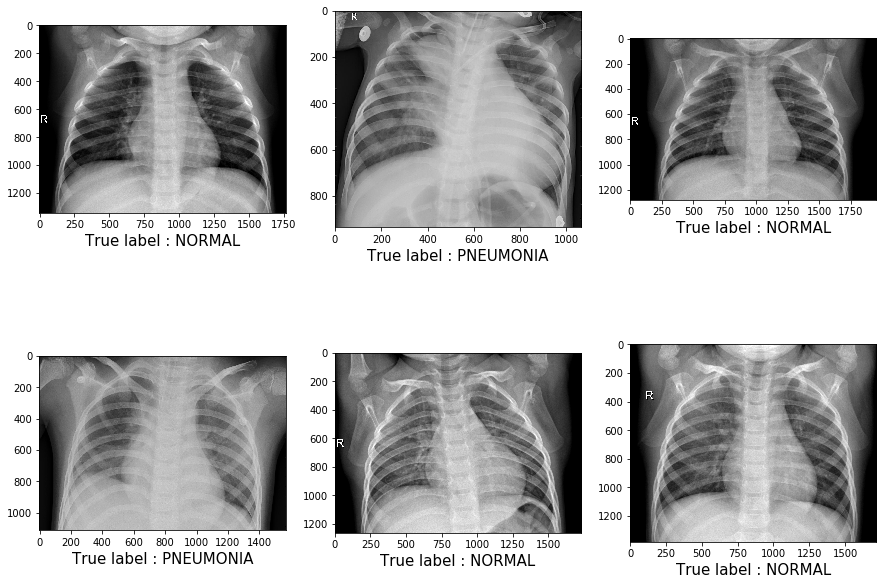

In [7]:
# visualise samples of normal and pneumonia images
visualise_images(samples_normal, samples_pneumonia)

- Images are of different sizes
- Some samples of NORMAL / PNEUMONIA images are shown

## Create train and test data generators

In [8]:
# Get generators
train_generator, validation_generator, test_generator = create_train_test_val_generator(train_path,test_path,\
                                                                                        val_path,img_size=(96,96),batch_size=16,
                                                                                        shear_range=0.3,zoom_range=0.3)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model Architecture

In [0]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=(96,96,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# If no improvement in validation loss, we stop the training
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# If no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

history = model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, 
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    epochs=20,
                   callbacks=[reducel, earlystopper])

Epoch 1/20
326/326 [==============================] - 71s 217ms/step - loss: 0.5755 - acc: 0.7477 - val_loss: 0.4170 - val_acc: 0.8077
Epoch 2/20
326/326 [==============================] - 68s 210ms/step - loss: 0.3927 - acc: 0.8244 - val_loss: 0.3986 - val_acc: 0.8317
Epoch 3/20
326/326 [==============================] - 69s 211ms/step - loss: 0.3317 - acc: 0.8589 - val_loss: 0.3489 - val_acc: 0.8606
Epoch 4/20
326/326 [==============================] - 69s 210ms/step - loss: 0.2854 - acc: 0.8825 - val_loss: 0.2847 - val_acc: 0.8766
Epoch 5/20
326/326 [==============================] - 69s 211ms/step - loss: 0.2825 - acc: 0.8951 - val_loss: 0.2765 - val_acc: 0.9071
Epoch 6/20
326/326 [==============================] - 69s 210ms/step - loss: 0.2573 - acc: 0.9038 - val_loss: 0.4028 - val_acc: 0.8830

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/20
326/326 [==============================] - 69s 211ms/step - loss: 0.1987 - acc: 0.9287 - val_loss

In [0]:
#model.save_weights('train_from_scratch_weights.h5')

## Epoch performances

In [0]:
results = history.history

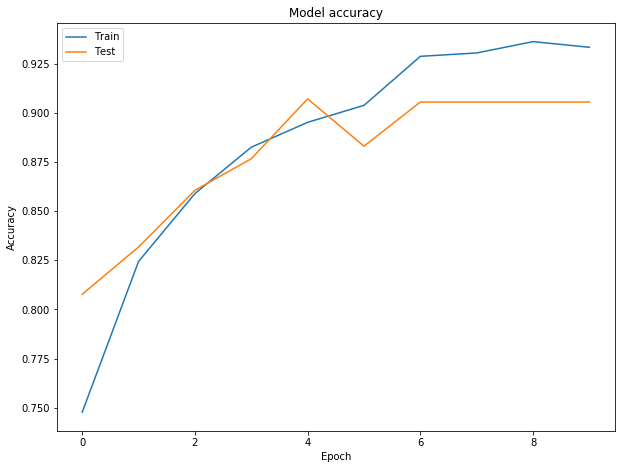

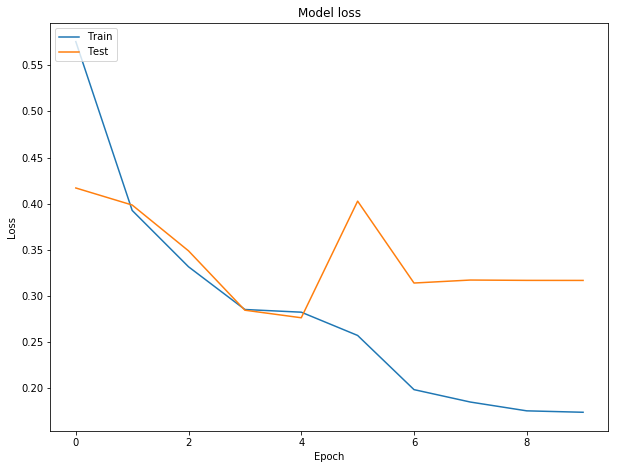

In [24]:
# summarize history for accuracy
plt.figure(figsize=(10,7.5))
plt.plot(results['acc'])
plt.plot(results['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(10,7.5))
plt.plot(results['loss'])
plt.plot(results['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

It seems that slight overfitting has occured after epoch 4, with the validation loss being higher than the training loss. What could have been done better is to reduce the complexity of the model by removing some convolution layers or reduce the no. of nodes in the second last dense layer. Nevertheless, we will still use this as our baseline model for now.

## Evaluation of trained model

In [31]:
# Get the results
results = model.evaluate_generator(validation_generator)

print('Loss : {}, Accuracy : {} '.format(results[0],results[1]))

Loss : 0.3269267678260803, Accuracy : 0.8125 


With an accuracy of 81.25%, this means that 3 out of the 16 samples in the test set are misclassified. We will look into this in the notebook ` `.